In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 数値型カラム情報確認 計38(うち14は選定済）

log_col = f'{col}_log'
    if log_col in train_df.columns:
        plt.subplot(5,2,2*i+2) #3行2列　i+1 何番のグラフか？
        sns.histplot(data=train_df, x=log_col, bins=30, kde=True)
        plt.title(f'log of{col}')
        plt.xlabel(col)
        plt.ylabel('Count')


### 対数変換

In [3]:
train_df['LotArea_log'] = np.log1p(train_df['LotArea'])

### 二値化

In [4]:
train_df['MiscVal_binary']=(train_df['MiscVal']>1000).astype(int)

train_df['HasPool']=(train_df['PoolArea']>0).astype(int)

train_df['Has3SsnPorch']=(train_df['3SsnPorch']>0).astype(int)

train_df['HasLowQualFinSF']=(train_df['LowQualFinSF']>0).astype(int)

train_df['HasExtraKitchen'] = (train_df['KitchenAbvGr'] > 1).astype(int)

train_df["HasBsmtFinSF2"] = (train_df["BsmtFinSF2"] > 0).astype(int)

train_df["HasScreenPorch"] = (train_df["ScreenPorch"] > 0).astype(int)

train_df['HasMasVnrArea'] = (train_df['MasVnrArea'] > 0).astype(int)

### **Bob_cox/Yeo-Johnson**

In [5]:
from scipy.stats import boxcox,yeojohnson
train_df['BsmtFinSF1_yeo'],lambda_a= yeojohnson(train_df['BsmtFinSF1'])
#train_df['TotalBsmtSF_yeo'],lambda_b= yeojohnson(train_df['TotalBsmtSF'])
#train_df['OpenPorchSF_yeo'],lambda_a= yeojohnson(train_df['OpenPorchSF'])
#train_df['WoodDeckSF_yeo'],lambda_a= yeojohnson(train_df['WoodDeckSF'])

#train_df['GrLivArea_boxcox'],lambda_a=boxcox(train_df['GrLivArea'])
#train_df['1stFlrSF_boxcox'],lambda_a=boxcox(train_df['1stFlrSF'])

### **カテゴリー変数（objectカラム→category)**

In [6]:
train_df.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [7]:
obj_cols = train_df.select_dtypes(include='object').columns
obj_nulls = train_df[obj_cols].isnull().sum()
obj_nulls = obj_nulls[obj_nulls>0]
print(obj_nulls)

Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [8]:
# object型カラムをすべて category 型に変換
for col in train_df.select_dtypes(include='object').columns:
    train_df[col] = train_df[col].astype('category')

In [9]:
#上位２０項目　category（リスト）
selected_categorical_features = [
    'Neighborhood', 'KitchenQual', 'ExterQual', 'FireplaceQu',
    'GarageFinish', 'MasVnrType', 'LotShape', 'CentralAir',
    'HouseStyle', 'BldgType', 'BsmtQual', 'BsmtExposure',
    'GarageType', 'ExterCond', 'Foundation', 'BsmtFinType1',
    'PavedDrive', 'Electrical', 'BsmtCond', 'SaleCondition']
   
#カテゴリー変数特徴量選定
cat_df = train_df[selected_categorical_features]#データフレームに変換 

#NaNをなしを意味するNoneへ補完
target_cols = ['FireplaceQu', 'GarageFinish', 'MasVnrType',
               'BsmtExposure', 'GarageType', 'BsmtFinType1', 'BsmtCond']

# 各列ごとにカテゴリ追加＆補完
for col in target_cols:
    if cat_df[col].dtype.name == 'category':
        #'None' をカテゴリに追加
        cat_df[col] = cat_df[col].cat.add_categories('None')
cat_df[target_cols] = cat_df[target_cols].fillna('None')
        
cat_df = cat_df.drop(columns=[
    'BsmtCond','BldgType','Foundation','Electrical','BsmtQual','HouseStyle',
    
])
cat_df.head()

,Neighborhood,KitchenQual,ExterQual,FireplaceQu,GarageFinish,MasVnrType,LotShape,CentralAir,BsmtExposure,GarageType,ExterCond,BsmtFinType1,PavedDrive,SaleCondition
0,CollgCr,Gd,Gd,None,RFn,BrkFace,Reg,Y,No,Attchd,TA,GLQ,Y,Normal
1,Veenker,TA,TA,TA,RFn,None,Reg,Y,Gd,Attchd,TA,ALQ,Y,Normal
2,CollgCr,Gd,Gd,TA,RFn,BrkFace,IR1,Y,Mn,Attchd,TA,GLQ,Y,Normal
3,Crawfor,Gd,TA,Gd,Unf,None,IR1,Y,No,Detchd,TA,ALQ,Y,Abnorml
4,NoRidge,Gd,Gd,TA,RFn,BrkFace,IR1,Y,Av,Attchd,TA,GLQ,Y,Normal


## **新しい特徴量作成**

In [10]:
#1階の比率
train_df["1stFlrSF_ratio"] = train_df["1stFlrSF"] / train_df["GrLivArea"]

#居住面積あたりのガレージの大きさ
train_df["Per_GLA_Gl"] = train_df["GarageArea"]/ train_df["GrLivArea"] 

#ガレージの面積あたりの車密度                                  
#train_df["GarageAreaPerCar"] = train_df["GarageCars"]/train_df["GarageArea"] 
# ゼロ除算を避けて、GarageCars=0のときは明示的に0を代入
train_df["GarageAreaPerCar"] = np.where(
    train_df["GarageCars"] == 0,
    0,
    train_df["GarageArea"] / train_df["GarageCars"]
)


#1台あたりのガレージ面積
train_df["GarageAreaPerCarInverse"] = train_df["GarageArea"] / train_df["GarageCars"]

#地下室の仕上げ率(未仕上げあり)
train_df['BsmtFinRatio'] = (train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']) / (train_df['TotalBsmtSF'] + 1)

#地下室の仕上げ率（未仕上げ除く）
train_df['BsmtFin_noUnf'] =	train_df['BsmtFinSF1'] + train_df['BsmtFinSF2'] / (train_df['TotalBsmtSF'] - train_df['BsmtUnfSF']+ 1)

#未仕上げを除いた実質有効面積
train_df["BsmtFin_1_2"]= train_df["BsmtFinSF1"] + train_df["BsmtFinSF2"]

#未仕上げ率
train_df['BsmtUnfRatio'] = train_df['BsmtUnfSF'] / (train_df['TotalBsmtSF'] + 1)

#販売年
train_df['SaleYearMonth'] = train_df['YrSold'] * 12 + train_df['MoSold']

#地上 vs 地下の比率
#train_df['TotalBsmtSF_GrLiveArea'] = train_df['TotalBsmtSF'] / train_df['GrLivArea'] 

#改装までの年数
#train_df['YearRemodAdd_YearBuilt'] = train_df['YearRemodAdd'] - train_df['YearBuilt']

# 平均部屋サイズ
#train_df['TotRmsAbvGrd_GrLivArea'] = train_df['TotRmsAbvGrd'] / train_df['GrLivArea']

# Neighborhoodごとの物件数を特徴量に
#neigh_count = train_df['Neighborhood'].value_counts()
#train_df['Neighborhood_Count'] = train_df['Neighborhood'].map(neigh_count)

In [11]:
#ハイパラ後特徴量追加

# 地上＋地下の総面積
train_df['TotalLivingArea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']

# ガレージ面積 / 地上床面積
train_df['GarageAreaRatio'] = train_df['GarageArea'] / train_df['GrLivArea']

# 地下仕上げ率（リークに注意）
#train_df['BsmtFinRatio'] = train_df['BsmtFinSF1_yeo'] / train_df['TotalBsmtSF'].replace(0, np.nan)

# 改築からの年数（建物のリフレッシュ度）
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']

# 築年数（古さ）
train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']

# 部屋1つあたりの床面積（生活のゆとり）
train_df['GlArea_per_Room'] = train_df['GrLivArea'] / train_df['TotRmsAbvGrd'].replace(0, np.nan)

# 敷地あたりのガレージ密度
train_df['GarageDensity'] = train_df['GarageArea'] / train_df['LotArea'].replace(0, np.nan)

# 部屋1つあたりの敷地面積
train_df['LotAreaPerRoom'] = train_df['LotArea'] / train_df['TotRmsAbvGrd'].replace(0, np.nan)

In [12]:
# --- LotFrontage の補完（Neighborhoodごとの中央値） ---
# groupby + transform による中央値の取得
#neighborhood_median = train_df.groupby("Neighborhood")["LotFrontage"].transform("median")

# 欠損値を補完
#train_df["LotFrontage_filled"] = train_df["LotFrontage"].fillna(neighborhood_median)


# --- GarageYrBlt の補完（YearBuiltを代入 or 0補完） ---
train_df["GarageYrBlt_filled"] = train_df["GarageYrBlt"]

# Garage があるのに欠損している行 → YearBuilt で補完
has_garage = train_df["GarageYrBlt"].isnull() & (train_df["GarageType"] != 'None')
train_df.loc[has_garage, "GarageYrBlt_filled"] = train_df.loc[has_garage, "YearBuilt"]

# Garage がない or 補完できない場合 → 0を代入
train_df["GarageYrBlt_filled"] = train_df["GarageYrBlt_filled"].fillna(0)


### 欠損値と外れ値処理

In [13]:
int_cols = train_df.select_dtypes(include='number').columns
int_nulls = train_df[int_cols].isnull().sum()
int_nulls = int_nulls[int_nulls>0]
print(int_nulls)

LotFrontage                259
MasVnrArea                   8
GarageYrBlt                 81
GarageAreaPerCarInverse     81
dtype: int64


In [14]:
missing_rows = train_df[["GarageYrBlt",'LotFrontage','MasVnrArea']].isnull().any(axis = 1)
missing_df = train_df[missing_rows]

print(missing_df[["GarageYrBlt", "LotFrontage", "MasVnrArea"]])

      GarageYrBlt  LotFrontage  MasVnrArea
7          1973.0          NaN       240.0
12         1962.0          NaN         0.0
14         1960.0          NaN       212.0
16         1970.0          NaN       180.0
24         1968.0          NaN         0.0
...           ...          ...         ...
1443       1916.0          NaN         0.0
1446       1962.0          NaN       189.0
1449          NaN         21.0         0.0
1450          NaN         60.0         0.0
1453          NaN         90.0         0.0

[339 rows x 3 columns]


### **数値カラム＋新特徴量（数値**）

In [15]:
# 対数変換＋クリップした値を _log にまとめる
log_cols = [
    'TotalBsmtSF', 
    'BsmtFin_1_2', '1stFlrSF', 'GrLivArea','LotAreaPerRoom','TotalLivingArea'
]

for col in log_cols:
    clip_upper = train_df[col].quantile(0.99)

    train_df[f'{col}_log'] = np.log1p(train_df[col].clip(upper=clip_upper))
    #test_df[f'{col}_log'] = np.log1p(test_df[col].clip(upper=clip_upper))

In [16]:
num_df = train_df.select_dtypes(include='number')
num_df_drop = num_df.drop(columns=[
    'Id', 'MasVnrArea', 'PoolArea', 'BsmtHalfBath', 'MiscVal','3SsnPorch',
    'LowQualFinSF', 'BsmtFinSF2','MoSold', 'YrSold','HalfBath',
     'KitchenAbvGr', 'EnclosedPorch', 'BsmtFullBath', 'MSSubClass',
    'OpenPorchSF','ScreenPorch','LotFrontage',
     'LotArea','WoodDeckSF','SalePrice','BsmtFinSF1',
    'FullBath','BedroomAbvGr',
    #新たな特徴量削除
    'BsmtFinRatio','BsmtFin_noUnf','BsmtUnfRatio','GarageAreaPerCarInverse',
    'MiscVal_binary','HasPool','HasExtraKitchen','HasLowQualFinSF','HasBsmtFinSF2',
    'HasScreenPorch','HasMasVnrArea','Has3SsnPorch',

    'TotalBsmtSF', 'TotalLivingArea','LotAreaPerRoom',
    'BsmtFin_1_2', '1stFlrSF', 'GrLivArea','GarageYrBlt'
])

#カテゴリー変数＋厳選数値カラム＋新特徴量　選定
x_train = pd.concat([cat_df,num_df_drop], axis=1)

# 目的変数
y_train = np.log1p(train_df["SalePrice"])

print(x_train.shape)
print(y_train.shape)

(1460, 42)
(1460,)


In [ ]:
x_train.isnull().sum()

In [ ]:
x_train.head()

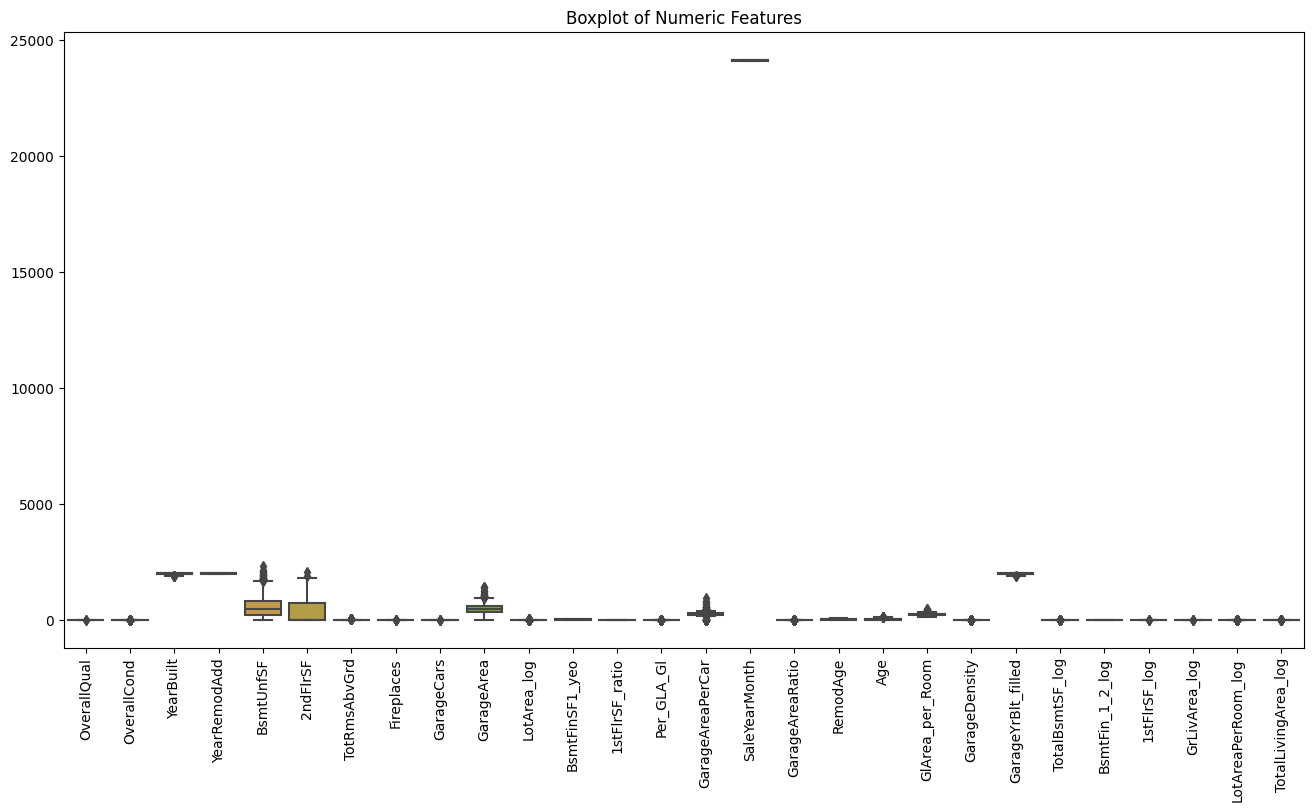

In [17]:
# 数値カラムだけ抽出
numeric_cols = x_train.select_dtypes(include=['number']).columns

# 複数特徴量を1つの箱ひげ図で（狭くなるので注意）
plt.figure(figsize=(16, 8))
sns.boxplot(data=x_train[numeric_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features")
plt.show()


## **クロスバリデーション**

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping,log_evaluation
import numpy as np

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 123,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    scores = []

    for train_idx, valid_idx in cv.split(x_train):
        x_tr, x_va = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=1000)
        model.fit(x_tr, y_tr,
                  eval_set=[(x_va, y_va)],
                  callbacks=[early_stopping(stopping_rounds=50)
                            ,log_evaluation(0)],
                  categorical_feature=categorical_cols)
        
        preds = model.predict(x_va)
        rmse = mean_squared_error(y_va, preds, squared=False)
        scores.append(rmse)

    return np.mean(scores)

# Optuna 実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Score:", study.best_value)
print("Best Params:", study.best_params)


In [ ]:
#元データ
categorical_cols = x_train.select_dtypes(include='category').columns.tolist()
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric":"rmse",
    "learning_rate":0.1,
    "num_leaves": 31, 
    "n_estimators": 100000,
    "random_state": 123,
    "importance_type":"gain",
    "verbose":-1,
    "categorical_feature" : categorical_cols #カテゴリ変数のリストを入れる
}

n_splits = 5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = []
imp = pd.DataFrame()

for nfold, (train_idx, val_idx) in enumerate(cv.split(x_train)):
    
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    print("train:", x_tr.shape, y_tr.shape)
    print("val:", x_va.shape, y_va.shape)
    
    model=lgb.LGBMRegressor(**params)
    model.fit(
          x_tr,
          y_tr, 
          eval_set=[(x_tr,y_tr), (x_va, y_va)],
          callbacks=[
              lgb.callback.early_stopping(stopping_rounds=100),
              lgb.callback.log_evaluation(period=100),
          ])

### ベスパラ初回　0.13065
categorical_cols = x_train.select_dtypes(include='category').columns.tolist()
best_params = {
    'learning_rate': 0.0211,
    'num_leaves': 80,
    'min_child_samples': 21,
    'reg_alpha': 0.316,
    'reg_lambda': 0.936,
    'feature_fraction': 0.882,
    'bagging_fraction': 0.642,
    'bagging_freq': 1,
    'n_estimators': 10000,  # early_stoppingに任せる
    'random_state': 123,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1
}

In [ ]:
#ハイパラ２
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb

def objective(trial):
    param = {
        'learning_rate': 0.0220,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'random_state': 123,
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'max_depth': 5,  # 固定
        'num_leaves': trial.suggest_int('num_leaves',24,48), #34,
        'min_child_samples': 15,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1,1.0), #0.316,    
        'reg_lambda': trial.suggest_float('reg_lambda',0.1,1.0), #0.936
        'feature_fraction': trial.suggest_float('feature_fraction',0.6,1.0),#0.882,
        'bagging_fraction': trial.suggest_float('bagging_fraction',0.5,1.0),#0.642,
        'bagging_freq': trial.suggest_int('bagging_freq',1,10),#1
    }

    scores = []
    cv = KFold(n_splits=5, shuffle=True, random_state=123)

    for train_idx, valid_idx in cv.split(x_train):
        x_tr, x_va = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = lgb.LGBMRegressor(**param)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_va, y_va)],
            eval_metric='rmse',
            callbacks=[
                lgb.callback.early_stopping(100),
                lgb.callback.log_evaluation(0)
            ],
            categorical_feature=categorical_cols
        )

        pred = model.predict(x_va)
        score = mean_squared_error(np.log1p(y_va), np.log1p(pred), squared=False)
        scores.append(score)

    return np.mean(scores)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # 試行回数は自由に調整

In [ ]:
print("Best trial:")
print(study.best_trial.params)

In [18]:
#ベスパラ実行
categorical_cols = x_train.select_dtypes(include='category').columns.tolist()
best_params = {
    'learning_rate': 0.0220,
    'num_leaves': 45,#1 80　2 34
    'max_depth': 5,  #デフォルト-1 
    'min_child_samples': 15,#21
    'reg_alpha': 0.1291, #0.316,
    'reg_lambda': 0.5470, #0.936,
    'feature_fraction': 0.6328, #0.882,
    'bagging_fraction': 0.5677,#0.642,
    'bagging_freq': 1,
    'n_estimators': 10000,  # early_stoppingに任せる
    'random_state': 123,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    #'num_boost_round': 5000,
'early_stopping_rounds':100

}
n_splits = 10

cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = []
imp = pd.DataFrame()

for nfold, (train_idx, val_idx) in enumerate(cv.split(x_train)):
    
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    print("train:", x_tr.shape, y_tr.shape)
    print("val:", x_va.shape, y_va.shape)

    model=lgb.LGBMRegressor(**best_params)
    model.fit(
          x_tr,
          y_tr, 
          eval_set=[(x_tr,y_tr), (x_va, y_va)],
          callbacks=[
              lgb.callback.early_stopping(stopping_rounds=50),
              lgb.callback.log_evaluation(period=100),
          ],categorical_feature=categorical_cols)



train: (1314, 42) (1314,)
val: (146, 42) (146,)
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.126219	valid_1's rmse: 0.140223
[200]	training's rmse: 0.0949053	valid_1's rmse: 0.113731
[300]	training's rmse: 0.0841466	valid_1's rmse: 0.108947
Early stopping, best iteration is:
[347]	training's rmse: 0.0802584	valid_1's rmse: 0.108034
train: (1314, 42) (1314,)
val: (146, 42) (146,)
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.127111	valid_1's rmse: 0.128171
[200]	training's rmse: 0.0949326	valid_1's rmse: 0.110077
[300]	training's rmse: 0.0838313	valid_1's rmse: 0.108516
[400]	training's rmse: 0.0759935	valid_1's rmse: 0.107939
Early stopping, best iteration is:
[374]	training's rmse: 0.0776969	valid_1's rmse: 0.107533
train: (1314, 42) (1314,)
val: (146, 42) (146,)
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.124908	valid_1's rmse: 0.139752
[200]	training's rmse: 0.0

In [19]:
#予測結果はlog変換済み
y_tr_pred_log = model.predict(x_tr)
y_va_pred_log = model.predict(x_va)

#実測値データもlog変換済み
y_tr_log = y_tr
y_va_log = y_va

#log変換同士の評価
rmse_tr_log = np.sqrt(mean_squared_error(y_tr_log, y_tr_pred_log))
rmse_va_log = np.sqrt(mean_squared_error(y_va_log, y_va_pred_log))

print(f"Train log RMSE: {rmse_tr_log:.4f}")
print(f"Validation log  RMSE: {rmse_va_log:.4f}")

metrics.append([nfold, rmse_tr_log, rmse_va_log])
_imp = pd.DataFrame({
        "col": x_train.columns,
        "imp": model.feature_importances_,
        'nfold': nfold
        })

imp = pd.concat([imp, _imp], axis=0, ignore_index=True)


Train log RMSE: 0.0802
Validation log  RMSE: 0.0960


In [20]:
metrics = np.array(metrics)
print(metrics)

print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),
))

[[9.         0.08024254 0.09601319]]
[cv ] tr: 0.08+-0.00, va: 0.10+-0.00


In [21]:
imp = imp.groupby("col")["imp"].agg(["mean"])
imp.columns = ["imp"]

imp_df = imp.sort_values(by='imp', ascending=False)
imp_df.head(50)

,imp
col,
TotalLivingArea_log,378.0
LotArea_log,356.0
GrLivArea_log,301.0
1stFlrSF_log,237.0
OverallCond,229.0
LotAreaPerRoom_log,226.0
GarageArea,220.0
Neighborhood,219.0
RemodAge,206.0


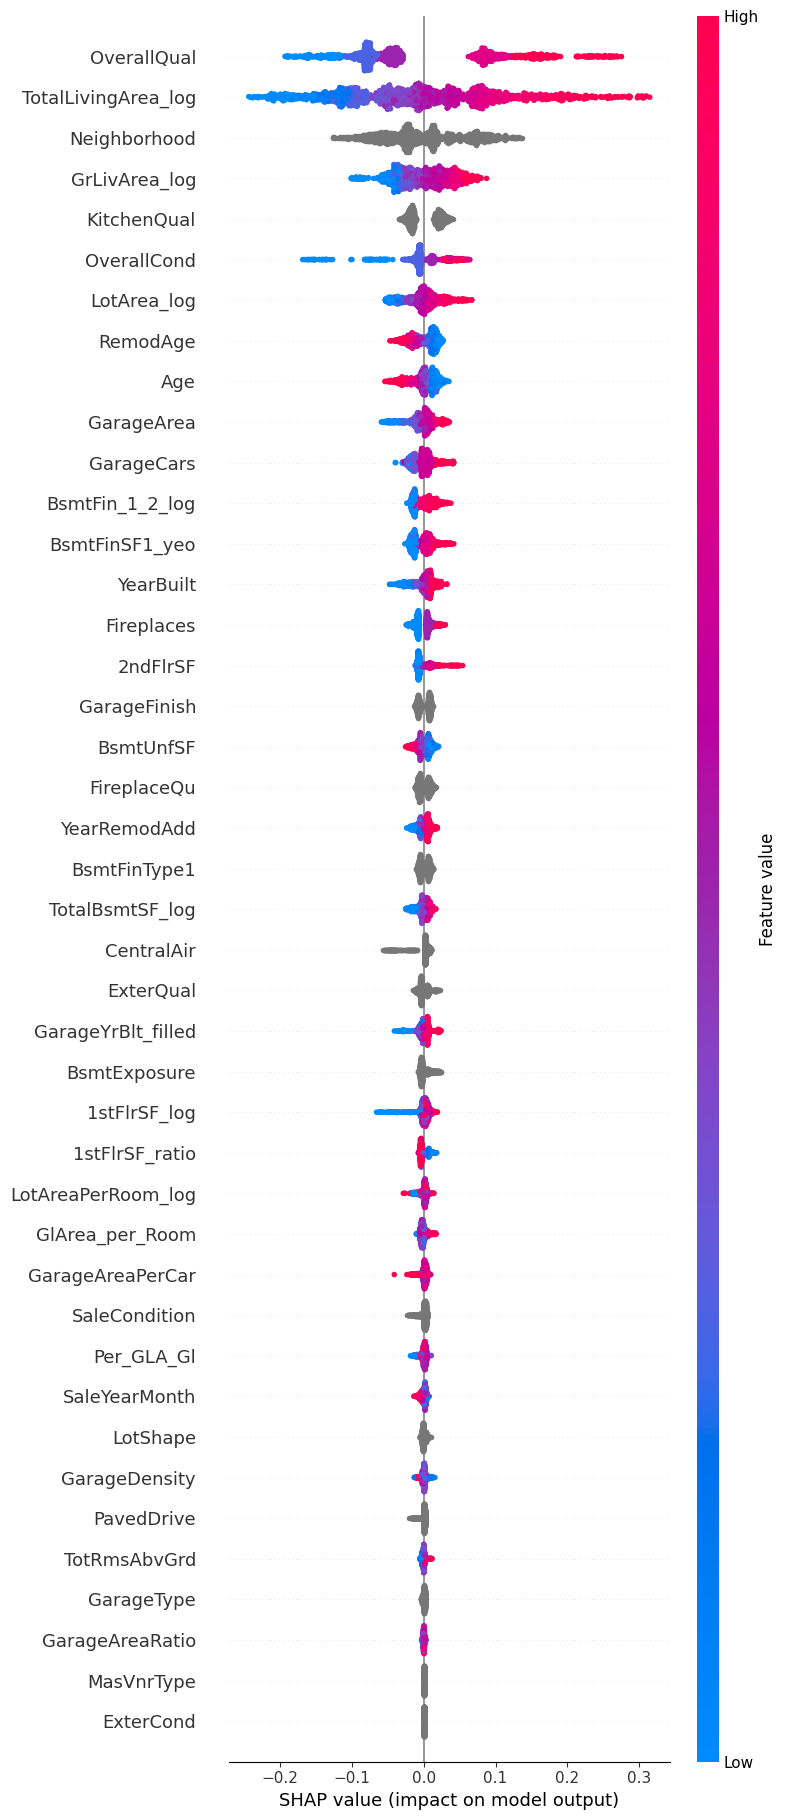

In [22]:
import shap
import lightgbm as lgb

# 学習済みモデル lgb_model、特徴量 X_train

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# グローバル可視化（全体の重要特徴量）
shap.summary_plot(shap_values, x_train,max_display=x_train.shape[1])

# 個別予測の説明
shap.force_plot(explainer.expected_value, shap_values[0], x_train.iloc[0])


## テスト用

In [23]:
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### **ワンホットエンコーディング/ラベルエンコーディング**

In [ ]:
#le=LabelEncoder()
#le.fit(test_df['MSSubClass'])

#test_df['MSSubClass_le']=le.transform(test_df['MSSubClass'])

In [24]:
#1階の比率
test_df["1stFlrSF_ratio"] = test_df["1stFlrSF"] / test_df["GrLivArea"]

#居住面積あたりのガレージの大きさ
test_df["Per_GLA_Gl"] = test_df["GarageArea"]/ test_df["GrLivArea"] 

#ガレージの面積あたりの車密度                                  
#test_df["GarageAreaPerCar"] = test_df["GarageCars"]/test_df["GarageArea"] 
# ゼロ除算を避けて、GarageCars=0のときは明示的に0を代入
test_df["GarageAreaPerCar"] = np.where(
    test_df["GarageCars"] == 0,
    0,
    test_df["GarageArea"] / test_df["GarageCars"]
)

#1台あたりのガレージ面積
test_df["GarageAreaPerCarInverse"] = test_df["GarageArea"] / test_df["GarageCars"]

#地下室の仕上げ率(未仕上げあり)
test_df['BsmtFinRatio'] = (test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']) / (test_df['TotalBsmtSF'] + 1)

#地下室の仕上げ率（未仕上げ除く）
test_df['BsmtFin_noUnf'] =	test_df['BsmtFinSF1'] + test_df['BsmtFinSF2'] / (test_df['TotalBsmtSF'] - test_df['BsmtUnfSF']+ 1)

#未仕上げを除いた実質有効面積
test_df["BsmtFin_1_2"]= test_df["BsmtFinSF1"] + test_df["BsmtFinSF2"]

#未仕上げ率
test_df['BsmtUnfRatio'] = test_df['BsmtUnfSF'] / (test_df['TotalBsmtSF'] + 1)

#販売年
test_df['SaleYearMonth'] = test_df['YrSold'] * 12 + test_df['MoSold']


In [25]:
# 地上＋地下の総面積
test_df['TotalLivingArea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

# ガレージ面積 / 地上床面積
test_df['GarageAreaRatio'] = test_df['GarageArea'] / test_df['GrLivArea']

# 改築からの年数（建物のリフレッシュ度）
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']

# 築年数（古さ）
test_df['Age'] = test_df['YrSold'] - test_df['YearBuilt']

# 部屋1つあたりの床面積（生活のゆとり）
test_df['GlArea_per_Room'] = test_df['GrLivArea'] / test_df['TotRmsAbvGrd'].replace(0, np.nan)

# 敷地あたりのガレージ密度
test_df['GarageDensity'] = test_df['GarageArea'] / test_df['LotArea'].replace(0, np.nan)

# 部屋1つあたりの敷地面積
test_df['LotAreaPerRoom'] = test_df['LotArea'] / test_df['TotRmsAbvGrd'].replace(0, np.nan)

In [26]:
# --- LotFrontage の補完（Neighborhoodごとの中央値） ---
# groupby + transform による中央値の取得
#neighborhood_median = test_df.groupby("Neighborhood")["LotFrontage"].transform("median")

# 欠損値を補完
#test_df["LotFrontage_filled"] = test_df["LotFrontage"].fillna(neighborhood_median)


# --- GarageYrBlt の補完（YearBuiltを代入 or 0補完） ---
test_df["GarageYrBlt_filled"] = test_df["GarageYrBlt"]

# Garage があるのに欠損している行 → YearBuilt で補完
has_garage = test_df["GarageYrBlt"].isnull() & (test_df["GarageType"] != 'None')
test_df.loc[has_garage, "GarageYrBlt_filled"] = test_df.loc[has_garage, "YearBuilt"]

# Garage がない or 補完できない場合 → 0を代入
test_df["GarageYrBlt_filled"] = test_df["GarageYrBlt_filled"].fillna(0)


In [27]:
# object型カラムをすべて category 型に変換
for col in test_df.select_dtypes(include='object').columns:
    test_df[col] = test_df[col].astype('category')

In [28]:
#上位２０項目　category（リスト）
selected_categorical_features = [
    'Neighborhood', 'KitchenQual', 'ExterQual', 'FireplaceQu',
    'GarageFinish', 'MasVnrType', 'LotShape', 'CentralAir',
    'HouseStyle', 'BldgType', 'BsmtQual', 'BsmtExposure',
    'GarageType', 'ExterCond', 'Foundation', 'BsmtFinType1',
    'PavedDrive', 'Electrical', 'BsmtCond', 'SaleCondition']
   
#カテゴリー変数特徴量選定
cat_df = test_df[selected_categorical_features]#データフレームに変換 

#NaNをなしを意味するNoneへ補完
target_cols = ['FireplaceQu', 'GarageFinish', 'MasVnrType',
               'BsmtExposure', 'GarageType', 'BsmtFinType1', 'BsmtCond']

# 各列ごとにカテゴリ追加＆補完
for col in target_cols:
    if cat_df[col].dtype.name == 'category':
        #'None' をカテゴリに追加
        cat_df[col] = cat_df[col].cat.add_categories('None')
cat_df[target_cols] = cat_df[target_cols].fillna('None')
        
cat_df = cat_df.drop(columns=[
    'BsmtCond','BldgType','HouseStyle','Foundation','Electrical','BsmtQual'
    
])
cat_df.head()

,Neighborhood,KitchenQual,ExterQual,FireplaceQu,GarageFinish,MasVnrType,LotShape,CentralAir,BsmtExposure,GarageType,ExterCond,BsmtFinType1,PavedDrive,SaleCondition
0,NAmes,TA,TA,None,Unf,None,Reg,Y,No,Attchd,TA,Rec,Y,Normal
1,NAmes,Gd,TA,None,Unf,BrkFace,IR1,Y,No,Attchd,TA,ALQ,Y,Normal
2,Gilbert,TA,TA,TA,Fin,None,IR1,Y,No,Attchd,TA,GLQ,Y,Normal
3,Gilbert,Gd,TA,Gd,Fin,BrkFace,IR1,Y,No,Attchd,TA,GLQ,Y,Normal
4,StoneBr,Gd,Gd,None,RFn,None,IR1,Y,No,Attchd,TA,ALQ,Y,Normal


def unify_categorical_columns(x_train, x_test, categorical_cols):
    """
    LightGBM用にx_trainとx_testのカテゴリ変数のカテゴリを統一する。
    """
    for col in categorical_cols:
        # train/test 両方のカテゴリを統合して明示
        all_cats = list(set(x_train[col].dropna().unique()) | set(x_test[col].dropna().unique()))
        
        x_train[col] = pd.Categorical(x_train[col], categories=all_cats)
        x_test[col]  = pd.Categorical(x_test[col], categories=all_cats)
        
    return x_train, x_test


categorical_cols = [
    'Neighborhood', 'KitchenQual', 'ExterQual', 'FireplaceQu',
    'GarageFinish', 'MasVnrType', 'LotShape', 'CentralAir',
    'BsmtExposure',
    'GarageType',  'BsmtFinType1','ExterCond',
    'PavedDrive', 'SaleCondition'
    # ここに使用している全てのカテゴリ変数を列挙
]

x_train, x_test = unify_categorical_columns(x_train, x_test, categorical_cols)


### 数値変換

In [29]:
test_df['LotArea_log'] = np.log1p(test_df['LotArea'])

In [30]:
test_df['MiscVal_binary']=(test_df['MiscVal']>1000).astype(int)

test_df['HasPool']=(test_df['PoolArea']>0).astype(int)

test_df['Has3SsnPorch']=(test_df['3SsnPorch']>0).astype(int)

test_df['HasLowQualFinSF']=(test_df['LowQualFinSF']>0).astype(int)

test_df['HasExtraKitchen'] = (test_df['KitchenAbvGr'] > 1).astype(int)

test_df["HasBsmtFinSF2"] = (test_df["BsmtFinSF2"] > 0).astype(int)

test_df["HasScreenPorch"] = (test_df["ScreenPorch"] > 0).astype(int)

test_df['HasMasVnrArea'] = (test_df['MasVnrArea'] > 0).astype(int)

In [31]:
# 欠損を train の中央値で補完し、Yeo-Johnson 変換を train の lambda_a で適用
test_df['BsmtFinSF1_yeo'] = yeojohnson(
    test_df['BsmtFinSF1'].fillna(train_df['BsmtFinSF1'].median()),
    lmbda=lambda_a
)


In [32]:
# 対数変換＋クリップした値を _log にまとめる
log_cols = [
     'TotalBsmtSF', 'LotAreaPerRoom','TotalLivingArea',
    'BsmtFin_1_2', '1stFlrSF', 'GrLivArea'
]

for col in log_cols:
    clip_upper = train_df[col].quantile(0.99)

    #train_df[f'{col}_log'] = np.log1p(train_df[col].clip(upper=clip_upper))
    test_df[f'{col}_log'] = np.log1p(test_df[col].clip(upper=clip_upper))


In [33]:
num_df = test_df.select_dtypes(include='number')
num_df_drop = num_df.drop(columns=[
    'Id', 'MasVnrArea', 'PoolArea', '3SsnPorch', 'BsmtHalfBath', 'MiscVal',
    'LowQualFinSF', 'BsmtFinSF2', 'BedroomAbvGr', 'MoSold', 'YrSold','HalfBath',
     'KitchenAbvGr', 'EnclosedPorch', 'BsmtFullBath', 'MSSubClass',
    'OpenPorchSF', 'LotFrontage','ScreenPorch',
     'LotArea','WoodDeckSF','FullBath','BsmtFinSF1',
    #新たな特徴量削除
   'BsmtFinRatio','BsmtFin_noUnf','BsmtUnfRatio','GarageAreaPerCarInverse',
    'MiscVal_binary','HasPool','HasExtraKitchen','HasLowQualFinSF','HasBsmtFinSF2',
   'HasScreenPorch','HasMasVnrArea','Has3SsnPorch',

    'TotalBsmtSF', 'LotAreaPerRoom','TotalLivingArea',
    'BsmtFin_1_2', '1stFlrSF', 'GrLivArea','GarageYrBlt'
])
# 数値＋カテゴリの特徴量を統合して x_train を再定義
x_test = pd.concat([
    cat_df,
    num_df_drop,
], axis=1)


### Catboost

In [ ]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'iterations': 1000,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 123,
        'verbose': 0,
        'early_stopping_rounds': 100
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    rmse_list = []

    for train_idx, val_idx in cv.split(x_train):
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=categorical_cols)
        val_pool = Pool(X_val, y_val, cat_features=categorical_cols)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=0)

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # 時間に応じて増やす


In [ ]:
print("Best trial:")
print(study.best_trial.params)

In [34]:
# ❶ 一時的に object 型に戻す（NaNを埋められるようにする）
categorical_cols = x_test.select_dtypes(include='category').columns.tolist()
for col in categorical_cols:
    x_train[col] = x_train[col].astype('object')
    x_test[col] = x_test[col].astype('object')

# ❷ NaN を 'Missing' に置換
x_train[categorical_cols] = x_train[categorical_cols].fillna('Missing')
x_test[categorical_cols] = x_test[categorical_cols].fillna('Missing')

# ❸ category 型に再変換（CatBoostに渡すため）
for col in categorical_cols:
    x_train[col] = x_train[col].astype('category')
    x_test[col] = x_test[col].astype('category')


In [35]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# --- 前提：y_trainはlog1p(SalePrice)、x_train/x_testは前処理済（カテゴリ変数含む） ---

# CatBoostパラメータ
cat_params = {
    'learning_rate': 0.046, #0.03,
    'depth': 6,
    'l2_leaf_reg': 1.49,#3.0,
    'bagging_temperature': 0.4008,
    'random_strength': 2,
    'border_count': 112,
    'iterations': 10000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 123,
    'verbose': 100,
    'early_stopping_rounds': 100
}

# カテゴリ変数（category型であることが前提）
categorical_cols = x_train.select_dtypes(include='category').columns.tolist()

# クロスバリデーション
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)

oof_preds = np.zeros(len(x_train))
test_preds = np.zeros(len(x_test))
fold_rmse_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train)):
    print(f"\nFold {fold + 1}")
    
    X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Pool形式（CatBoost用）
    train_pool = Pool(X_tr, y_tr, cat_features=categorical_cols)
    valid_pool = Pool(X_val, y_val, cat_features=categorical_cols)
    test_pool = Pool(x_test, cat_features=categorical_cols)
    
    # モデル学習
    model = CatBoostRegressor(**cat_params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    
    # 予測と保存
    val_pred = model.predict(X_val)
    oof_preds[val_idx] = val_pred
    test_preds += model.predict(x_test) / n_splits
    
    rmse = mean_squared_error(y_val, val_pred, squared=False)
    fold_rmse_list.append(rmse)
    print(f"Fold {fold + 1} RMSE (log): {rmse:.5f}")

# OOF全体のスコア
oof_rmse = mean_squared_error(y_train, oof_preds, squared=False)
print(f"\nMean Fold RMSE (log): {np.mean(fold_rmse_list):.5f}")
print(f"OOF log RMSE: {oof_rmse:.5f}")

# --- 提出用CSV出力 ---
#submission = pd.DataFrame({
    #'Id': test_df['Id'],
    #'SalePrice': np.expm1(test_preds)  # log1p変換済を戻す
#})
#submission.to_csv('submission_catboost_foldmean.csv', index=False)



Fold 1
0:	learn: 0.3878345	test: 0.3879459	best: 0.3879459 (0)	total: 62.8ms	remaining: 10m 28s
100:	learn: 0.1209135	test: 0.1221236	best: 0.1221236 (100)	total: 797ms	remaining: 1m 18s
200:	learn: 0.0949574	test: 0.1090536	best: 0.1090536 (200)	total: 1.54s	remaining: 1m 15s
300:	learn: 0.0800496	test: 0.1052785	best: 0.1052571 (299)	total: 2.29s	remaining: 1m 13s
400:	learn: 0.0696034	test: 0.1048123	best: 0.1047212 (386)	total: 3.04s	remaining: 1m 12s
500:	learn: 0.0624717	test: 0.1037844	best: 0.1037747 (493)	total: 3.81s	remaining: 1m 12s
600:	learn: 0.0561726	test: 0.1034781	best: 0.1031337 (580)	total: 4.56s	remaining: 1m 11s
700:	learn: 0.0505351	test: 0.1025945	best: 0.1025155 (697)	total: 5.34s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1025155145
bestIteration = 697

Shrink model to first 698 iterations.
Fold 1 RMSE (log): 0.10252

Fold 2
0:	learn: 0.3908244	test: 0.3610490	best: 0.3610490 (0)	total: 7.03ms	remaining: 1m 10s
100:

### アンサンブル

In [ ]:
#Lightgbm
y_test_pred_log = np.zeros(len(x_test))  # 予測値蓄積用

for train_idx, val_idx in cv.split(x_train):
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_va, y_va)],
        callbacks=[lgb.callback.early_stopping(stopping_rounds=50)],
        categorical_feature=categorical_cols
    )

    # foldごとにテストデータ予測
    y_test_pred_log += model.predict(x_test)

# fold平均をとる
y_test_pred_log /= n_splits

# 逆対数変換して提出用ファイル作成
#y_test_pred = np.expm1(y_test_pred_log)
#submission = pd.DataFrame({
    #'Id': test_df['Id'],
    #'SalePrice': y_test_pred
#})
#submission.to_csv("submission.csv", index=False)


In [ ]:
ensemble_log = (test_preds + y_test_pred_log) / 2
y_pred_ensemble = np.expm1(ensemble_log)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_pred_ensemble})
submission.to_csv('submission_ensemble_last.csv', index=False)

In [ ]:
ensemble_log = 0.9 * test_preds + 0.1 * y_test_pred_log
y_pred_ensemble = np.expm1(ensemble_log)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_pred_ensemble})
submission.to_csv('submission_ensemble_last.csv', index=False)

In [ ]:
print(y_pred_ensemble)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(test_preds, label='CatBoost log_preds')
sns.kdeplot(y_test_pred_log, label='LightGBM log_preds')
plt.legend()
plt.title('log1p predictions distribution')
plt.show()


In [ ]:
print(y_train)


### スタッキング

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

# --- パラメータ設定 ---
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- OOF予測用配列（trainデータ数とtestデータ数で初期化）---
oof_cat = np.zeros(len(x_train))
oof_lgb = np.zeros(len(x_train))
test_pred_cat = np.zeros(len(x_test))
test_pred_lgb = np.zeros(len(x_test))

# --- 各foldで学習・予測 ---
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train)):
    print(f"\nFold {fold + 1}")
    
    X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # CatBoost
    train_pool = Pool(X_tr, y_tr, cat_features=categorical_cols)
    valid_pool = Pool(X_val, y_val, cat_features=categorical_cols)
    model_cat = CatBoostRegressor(**cat_params)
    model_cat.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=0)
    oof_cat[val_idx] = model_cat.predict(X_val)
    test_pred_cat += model_cat.predict(x_test) / n_splits
    
    # LightGBM
    model_lgb = lgb.LGBMRegressor(**best_params)
    model_lgb.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100)],
        categorical_feature=categorical_cols
    )
    oof_lgb[val_idx] = model_lgb.predict(X_val)
    test_pred_lgb += model_lgb.predict(x_test) / n_splits

# --- メタモデル用データ構築 ---
stacked_train = np.vstack([oof_cat, oof_lgb]).T  # (n_samples, 2)
stacked_test = np.vstack([test_pred_cat, test_pred_lgb]).T  # (n_test, 2)

# --- 標準化 ---
scaler = StandardScaler()
stacked_train_std = scaler.fit_transform(stacked_train)
stacked_test_std = scaler.transform(stacked_test)

meta_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
meta_model.fit(stacked_train_std, y_train)

final_preds_log = meta_model.predict(stacked_test_std)
final_preds = np.expm1(final_preds_log)


# --- メタモデル学習（Ridge回帰） ---
#meta_model = Ridge(alpha=1.0)
#meta_model.fit(stacked_train_std, y_train)

# --- メタモデルによる予測 ---
#final_preds_log = meta_model.predict(stacked_test_std)
#final_preds = np.expm1(final_preds_log)  # 逆log変換で元スケールに戻す

# --- 提出用ファイル作成 ---
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': final_preds
})
submission.to_csv("submission_stacking1.csv", index=False)

# --- OOF評価 ---
oof_rmse = mean_squared_error(y_train, meta_model.predict(stacked_train_std), squared=False)
print(f"\n[Stacking] OOF log RMSE: {oof_rmse:.5f}")



In [ ]:
y_test_pred_log = model.predict(x_test)
y_test_pred = np.expm1(y_test_pred_log)

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': y_test_pred
})
submission.to_csv("submission.csv", index=False)
